Compare LSTM implementations on the IMDB sentiment classification task.

implementation=0 preprocesses input to the LSTM which typically results in
faster computations at the expense of increased peak memory usage as the
preprocessed input must be kept in memory.

implementation=1 does away with the preprocessing, meaning that it might take
a little longer, but should require less peak memory.

implementation=2 concatenates the input, output and forget gate's weights
into one, large matrix, resulting in faster computation time as the GPU can
utilize more cores, at the expense of reduced regularization because the same
dropout is shared across the gates.

Note that the relative performance of the different implementations can
vary depending on your device, your model and the size of your data.

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Embedding, Dense, LSTM, Dropout
from keras.datasets import imdb

Using TensorFlow backend.


In [2]:
max_features = 20000
max_length = 80
embedding_dim = 256
batch_size = 128
epochs = 10
modes = [0, 1, 2]

print('Loading data...')
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=max_features)
X_train = sequence.pad_sequences(X_train, max_length)
X_test = sequence.pad_sequences(X_test, max_length)

Loading data...


In [12]:
imbd_dat = imdb.load_data()

In [13]:
type(imbd_dat)

tuple

In [6]:
# Compile and train different models while measuring performance.
results = []
for mode in modes:
    print('Testing mode: implementation={}'.format(mode))

    model = Sequential()
    model.add(Embedding(max_features, embedding_dim,
                        input_length=max_length))
    model.add(Dropout(0.2))
    model.add(LSTM(embedding_dim,
                   dropout=0.2,
                   recurrent_dropout=0.2,
                   implementation=mode))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    start_time = time.time()
    history = model.fit(X_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_data=(X_test, y_test))
    average_time_per_epoch = (time.time() - start_time) / epochs

    results.append((history, average_time_per_epoch))

Testing mode: implementation=0
Train on 25000 samples, validate on 25000 samples
Epoch 1/10
25000/25000 [==============================] - 28s - loss: 0.4638 - acc: 0.7783 - val_loss: 0.3742 - val_acc: 0.8352
Epoch 2/10
25000/25000 [==============================] - 25s - loss: 0.2928 - acc: 0.8823 - val_loss: 0.3760 - val_acc: 0.8318
Epoch 3/10
25000/25000 [==============================] - 24s - loss: 0.2267 - acc: 0.9119 - val_loss: 0.5202 - val_acc: 0.8027
Epoch 4/10
25000/25000 [==============================] - 24s - loss: 0.1708 - acc: 0.9363 - val_loss: 0.4898 - val_acc: 0.8102
Epoch 5/10
25000/25000 [==============================] - 25s - loss: 0.1273 - acc: 0.9535 - val_loss: 0.5042 - val_acc: 0.8204
Epoch 6/10
25000/25000 [==============================] - 26s - loss: 0.1019 - acc: 0.9626 - val_loss: 0.6858 - val_acc: 0.8188
Epoch 7/10
25000/25000 [==============================] - 25s - loss: 0.0837 - acc: 0.9706 - val_loss: 0.5923 - val_acc: 0.8020
Epoch 8/10
25000/25000 

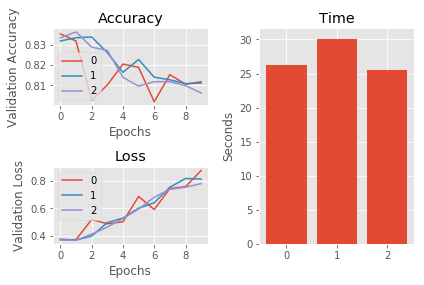

In [7]:
# Compare models' accuracy, loss and elapsed time per epoch.
plt.style.use('ggplot')
ax1 = plt.subplot2grid((2, 2), (0, 0))
ax1.set_title('Accuracy')
ax1.set_ylabel('Validation Accuracy')
ax1.set_xlabel('Epochs')
ax2 = plt.subplot2grid((2, 2), (1, 0))
ax2.set_title('Loss')
ax2.set_ylabel('Validation Loss')
ax2.set_xlabel('Epochs')
ax3 = plt.subplot2grid((2, 2), (0, 1), rowspan=2)
ax3.set_title('Time')
ax3.set_ylabel('Seconds')
for mode, result in zip(modes, results):
    ax1.plot(result[0].epoch, result[0].history['val_acc'], label=mode)
    ax2.plot(result[0].epoch, result[0].history['val_loss'], label=mode)
ax1.legend()
ax2.legend()
ax3.bar(np.arange(len(results)), [x[1] for x in results],
        tick_label=modes, align='center')
plt.tight_layout()
plt.show()